<a href="https://colab.research.google.com/github/manitprats/Time-Series-Forecasting/blob/main/FNN_Time_series_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
import math

from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


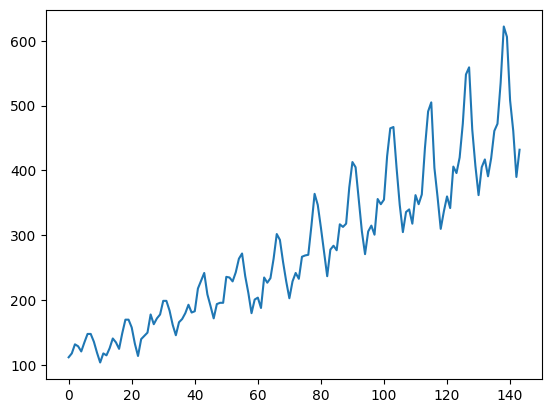

In [20]:
# load the dataset
dataframe = read_csv('/content/drive/MyDrive/Data/AirPassengers.csv', usecols=[1])
plt.plot(dataframe)

In [21]:
#Convert pandas dataframe to numpy array
dataset = dataframe.values
dataset = dataset.astype('float32') #COnvert values to float

In [22]:
# Normalization is optional but recommended for neural network as certain 
# activation functions are sensitive to magnitude of numbers. 
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1)) #Also try QuantileTransformer
dataset = scaler.fit_transform(dataset)


In [23]:
#We cannot use random way of splitting dataset into train and test as
#the sequence of events is important for time series.
#So let us take first 60% values for train and the remaining 1/3 for testing
# split into train and test sets
train_size = int(len(dataset) * 0.66)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [24]:
def to_sequences(dataset, seq_size=1):
    x = []
    y = []

    for i in range(len(dataset)-seq_size-1):
        #print(i)
        window = dataset[i:(i+seq_size), 0]
        x.append(window)
        y.append(dataset[i+seq_size, 0])
        
    return np.array(x),np.array(y)

In [25]:
seq_size = 10 # Number of time steps to look back 
#Larger sequences (look further back) may improve forecasting.
trainX, trainY = to_sequences(train, seq_size)
testX, testY = to_sequences(test, seq_size)

In [26]:

#Compare trainX and dataset. You can see that X= values at t, t+1 and t+2
#whereas Y is the value that follows, t+3 (since our sequence size is 3)

print("Shape of training set: {}".format(trainX.shape))
print("Shape of test set: {}".format(testX.shape))

Shape of training set: (84, 10)
Shape of test set: (38, 10)


In [27]:
#Input dimensions are... (N x seq_size)
print('Build deep model...')
# create and fit dense model
model = Sequential()
model.add(Dense(64, input_dim=seq_size, activation='relu')) #12
model.add(Dense(32, activation='relu'))  #8
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics = ['acc'])
print(model.summary()) 

Build deep model...
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 64)                704       
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2,817
Trainable params: 2,817
Non-trainable params: 0
_________________________________________________________________
None


In [28]:

model.fit(trainX, trainY, validation_data=(testX, testY),
          verbose=2, epochs=100)

Epoch 1/100
3/3 - 1s - loss: 0.0034 - acc: 0.0119 - val_loss: 0.0213 - val_acc: 0.0263 - 1s/epoch - 339ms/step
Epoch 2/100
3/3 - 0s - loss: 0.0035 - acc: 0.0119 - val_loss: 0.0127 - val_acc: 0.0263 - 54ms/epoch - 18ms/step
Epoch 3/100
3/3 - 0s - loss: 0.0026 - acc: 0.0119 - val_loss: 0.0115 - val_acc: 0.0263 - 58ms/epoch - 19ms/step
Epoch 4/100
3/3 - 0s - loss: 0.0023 - acc: 0.0119 - val_loss: 0.0109 - val_acc: 0.0263 - 43ms/epoch - 14ms/step
Epoch 5/100
3/3 - 0s - loss: 0.0023 - acc: 0.0119 - val_loss: 0.0103 - val_acc: 0.0263 - 62ms/epoch - 21ms/step
Epoch 6/100
3/3 - 0s - loss: 0.0019 - acc: 0.0119 - val_loss: 0.0078 - val_acc: 0.0263 - 43ms/epoch - 14ms/step
Epoch 7/100
3/3 - 0s - loss: 0.0018 - acc: 0.0119 - val_loss: 0.0071 - val_acc: 0.0263 - 41ms/epoch - 14ms/step
Epoch 8/100
3/3 - 0s - loss: 0.0016 - acc: 0.0119 - val_loss: 0.0073 - val_acc: 0.0263 - 55ms/epoch - 18ms/step
Epoch 9/100
3/3 - 0s - loss: 0.0015 - acc: 0.0119 - val_loss: 0.0065 - val_acc: 0.0263 - 54ms/epoch - 18m

In [29]:
# make predictions

trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# Estimate model performance
#SInce we used minmaxscaler we can now use scaler.inverse_transform
#to invert the transformation.

trainPredict = scaler.inverse_transform(trainPredict)
trainY_inverse = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY_inverse = scaler.inverse_transform([testY])

2/2 [==============================] - 0s 5ms/step


In [32]:
len(trainX)

84

In [33]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY_inverse[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))

testScore = math.sqrt(mean_squared_error(testY_inverse[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 9.20 RMSE
Test Score: 23.54 RMSE


In [34]:
# shift train predictions for plotting
#we must shift the predictions so that they align on the x-axis with the original dataset. 
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[seq_size:len(trainPredict)+seq_size, :] = trainPredict


In [35]:
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(seq_size*2)+1:len(dataset)-1, :] = testPredict


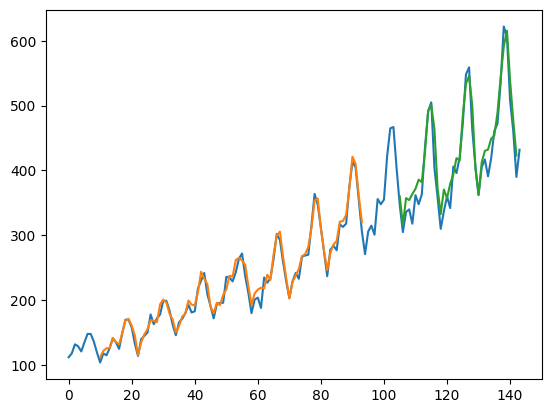

In [36]:
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()